In [1]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
import cv2
from torchvision import transforms
from scipy.ndimage.interpolation import zoom
import itertools
import pickle
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
from IPython import display 
device = torch.device('cpu')

In [2]:
def diffeq(t,x):
    mu = -1
    if len(x) == 2:
        u = x[0]
        v = x[1]
    else:
        u = x[:,0]
        v = x[:,1]

    dudt = mu*u - v + u*v**2
    dvdt = u + mu*v + v**3
    if isinstance(dudt, torch.Tensor):
        A = [dudt.numpy(), dvdt.numpy()]
    else:
        A = [dudt, dvdt]
    return np.array(A)

In [38]:
%run Supporting_Function.py
%run ODE_Func.py
%run Ploting_Function.py

In [44]:
orig_trajs, samp_trajs, orig_ts, samp_ts = generateData(1000, diffeq, [-0.25, 0.25], 1)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

In [42]:
orig_trajs, samp_trajs, orig_ts, samp_ts = generateData(1000, diffeq, [-0.25, 0.25], 1)

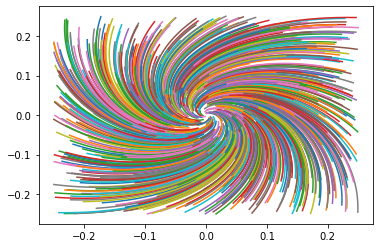

In [43]:
plt.figure()
for i in range(1000):
    plt.plot(samp_trajs[i,:,0], samp_trajs[i,:,1])
plt.show()

In [45]:
func = ODEFunc(2, 40, 40, nlayer_V= 2, n_V=5)
# func.apply(init_weights)
lr = 0.01
samp_trajs_grad = samp_trajs.detach().requires_grad_(True)
params = list(func.parameters())
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
pred_steps = 500
OldParams = None
min_loss = 10000000
lmbda = 0.0001

In [47]:
try:
    for itr in range(1, 20000):
        optimizer.zero_grad()
        pred_x = odeint(func, samp_trajs_grad[:,0, :], samp_ts, method = 'euler').permute(1, 0, 2)
        L2 = ((pred_x - samp_trajs)**2).sum()
        #a,b,c,d = func.metric_nn(samp_trajs_grad[:,0, :]).split(1,1)
        #L1 = torch.log((a*d-b*c)**2).sum()
        loss = L2
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}'.format(itr, -loss_meter.avg))
    
        if loss_meter.avg <= min_loss:
          torch.save(func, 'min_func.pt')
          min_loss = loss_meter.avg
          print("min model_updated")

except KeyboardInterrupt:

    print('Training complete after {} iters.'.format(itr))

Iter: 1428, MSE loss: -7853.8461
Training complete after 1429 iters.


In [11]:
min_loss

-127.213492124709

In [7]:
min_func = torch.load('min_func.pt')

In [9]:
torch.save(min_func, 'min_func_03_28.pt')

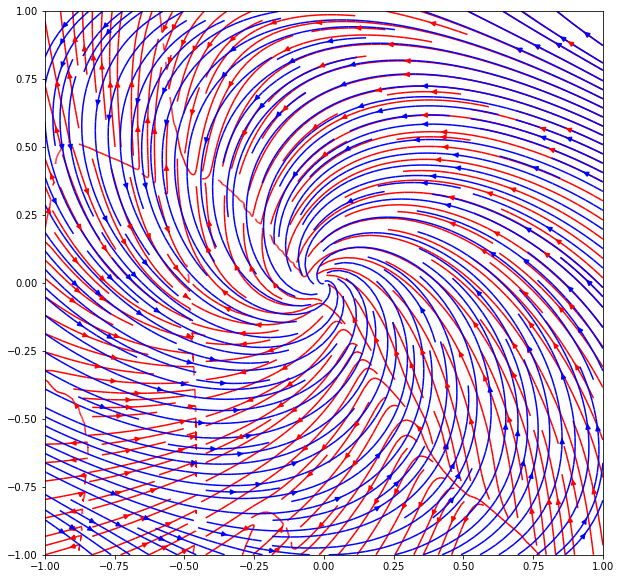

In [8]:
plot_func(min_func, diffeq)

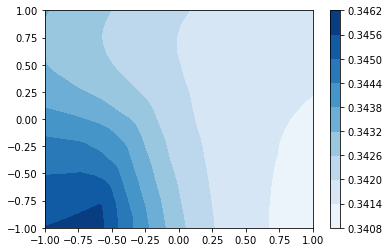

In [48]:
plot_V(min_func, continuous=False)

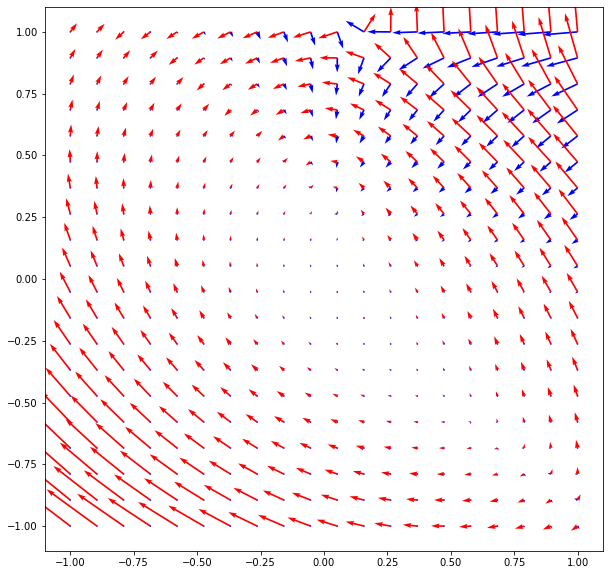

In [55]:
plot_Eigval(min_func)

In [53]:
for i in range(10):
    func = ODEFunc(2, 40, 40, nlayer_V= 2, n_V=3)
    # func.apply(init_weights)
    lr = 0.01
    N_grad = N.detach().requires_grad_(True)
    params = list(func.parameters())
    optimizer = optim.Adam(params, lr=lr)
    loss_meter = RunningAverageMeter()
    pred_steps = 500
    OldParams = None
    min_loss = 10000000
    lmbda = 0.01

    for itr in range(1, 20000):
        optimizer.zero_grad()

        L2 = ((func(0,N_grad) - V_norm)**2).sum()
        a,b,c,d = func.metric_nn(N_grad).split(1,1)
        L1 = torch.log((a*d-b*c)**2).sum()
        loss = L2 - lmbda*L1
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        NewParams = plot_params(params, plot = False)
        update_bool = True
        if OldParams is not None:
          update_bool = not (NewParams==OldParams).all()
        OldParams = NewParams
        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}, Update Param: {}'.format(itr, -loss_meter.avg, update_bool))

        if loss_meter.avg < min_loss:
          name = 'min_func_' + str(i) + '.pt' 
          torch.save(func, name)

Iter: 19999, MSE loss: -7889.7938, Update Param: True


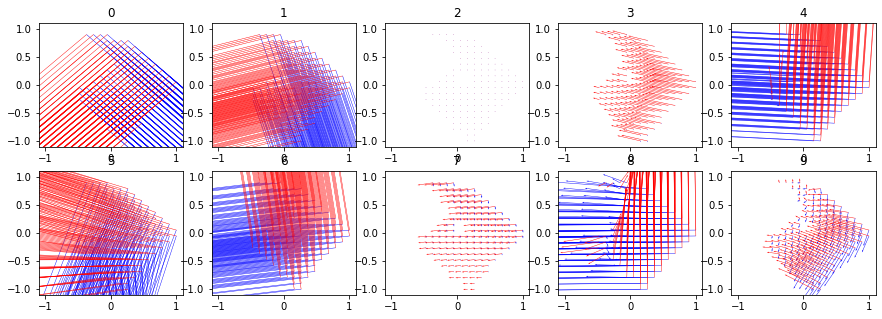

In [49]:
fig, axs = plt.subplots(2, 5)
fig.set_figheight(5)
fig.set_figwidth(15)
n = 10
for i,j in itertools.product(range(2),range(5)):
  name_str = 'min_func_' + str(i*5+j) + '.pt'
  func = torch.load(name_str)
  coord, eigvec1, eigvec2 = get_data_eig(func, 20, 2, eig_type = 'vector')
  x, y = coord
  u1, v1 = eigvec1
  u2, v2 = eigvec2
  axs[i,j].quiver(x,y,u1,v1, color= 'b',angles='xy', scale_units='xy', scale=10**n)
  axs[i,j].quiver(x,y,u2,v2, color='r',angles='xy', scale_units='xy', scale=10**n)
  axs[i,j].set_title(str(i*5+j))

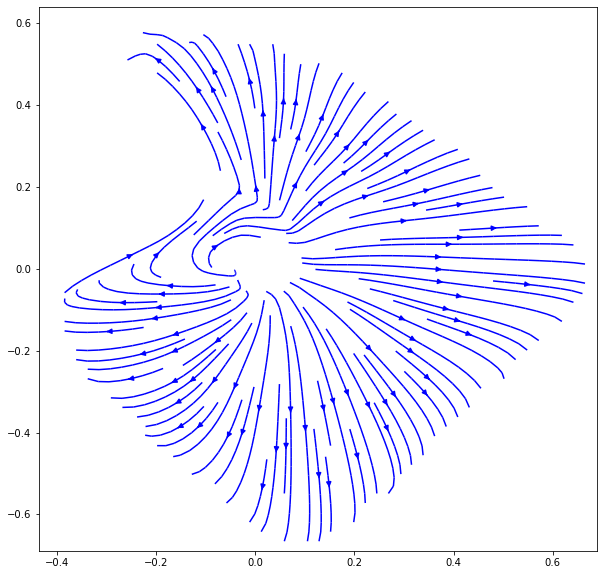

In [52]:
func = torch.load('min_func_0.pt')
plot_func(func)